In [11]:
%matplotlib inline
#%matplotlib widget

In [12]:
#############imports######################################################################
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact
import scipy as sc
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d


In [13]:
def timeToSec(timeStr):#Transform m:s format into total number of seconds
    timeArr = timeStr.split(':')
    timeMin = float(timeArr[0])
    timeSec = float(timeArr[1])
    totSec = timeMin*60+timeSec
    return totSec
def thetafit(theta,A,B):
    return A*np.sin(theta+B)
def expShift(t,A,C):
    return np.exp(A*(t))*C
def linearfit(x,A,B):
    return A*x+B

In [19]:
expSumFileName ='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\kappa_meas_made_bots\\kappa_exp.csv'
expSum = pd.read_csv(expSumFileName,index_col=0)
fps=25
#indexes=np.r_[3:63, 73:202].tolist()
#indexes=np.r_[182].tolist()
#expSum=expSum.iloc[range(0,13)]
expSum=expSum[(expSum.starting_point=='up')]
print(expSum)

           date operator  bottype  No..1  angle  angle_err  stars  bots  \
No.                                                                       
1    20240617.0     Eden  fronter      5    5.4        0.1    NaN   NaN   
2           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
3           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
4           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
5           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
..          ...      ...      ...    ...    ...        ...    ...   ...   
355         NaN      NaN  aligner      3    0.8        0.2    NaN   NaN   
356         NaN      NaN  aligner      3    0.8        0.2    NaN   NaN   
357         NaN      NaN  aligner      3    0.8        0.2    NaN   NaN   
358         NaN      NaN  aligner      3    0.8        0.2    NaN   NaN   
359         NaN      NaN  aligner      3    0.8        0.2    NaN   NaN   

                        

In [20]:
data = {'filename':[],'slope':[],'slope_err':[],'bottype':[],'A':[],'index':[],'starting_point':[],'p0_1':[],'p0_2':[]}
columns = ['filename','slope','slope_err','bottype','A','index','starting_point','p0_1','p0_2']
data_table = pd.DataFrame(data=data,columns=columns)
count=0
for index,row in (expSum.iterrows()):
    print(index)
    path_bot=row.BotLocatingFile#expSum.LocatingFile
    path_battery=row.BatteryLocatingFile
    startMin =row.start_min#row.start_min
    endMin =row.end_min#row.end_min
    start_point=timeToSec(startMin)*25#6000
    end_point=(timeToSec(endMin))*25#8000#frameCount
    df_bot=pd.read_csv(path_bot,index_col=0)
    #df=df[((df.frame<end_point)&(df.frame>=start_point))]
    df_battery=pd.read_csv(path_battery,index_col=0)
    evec_x_array=[]
    evec_y_array=[]
    frames=[]
    for frame in np.arange(start_point,end_point):
        try:
            relevant_data_bot=df_bot[(df_bot.frame==frame)]
            relevant_data_battery=df_battery[(df_battery.frame==frame)]
            evec_x=(relevant_data_bot.x.iloc[0] - relevant_data_battery.x.iloc[0])
            evec_y=-(relevant_data_bot.y.iloc[0] - relevant_data_battery.y.iloc[0])
            evec_x_array.append(evec_x)
            evec_y_array.append(evec_y)
            frames.append(frame)
        except:
            continue
    evec_x_array=np.array(evec_x_array)
    evec_y_array=np.array(evec_y_array)
    theta=np.arctan2(evec_y_array,evec_x_array)
    cond=theta<0
    cond=cond.astype(int)
    cond=cond*2*np.pi
    theta=theta+cond
    results=pd.DataFrame({'frame':frames,'theta':theta})
    y_plot=np.tan(theta/2)
    valid=(y_plot<1e10)#1/np.tan(2*results.theta)#+1/np.sin(results.theta)
    #plt.plot(results.theta,theta_V)
    t=results.frame/25
    if (np.isnan(row.p0_1)&np.isnan(row.p0_2)):
        p0=np.array([0.2,1])
    else:
        p0=np.array([row.p0_1,row.p0_2])
    sucsses=False
    count=0
#popt,pcov = sc.optimize.curve_fit(expShift,t[valid],y_plot[valid],p0=p0,maxfev=5000)

    while sucsses==False:
        try:
            popt,pcov = sc.optimize.curve_fit(expShift,t[valid],y_plot[valid],p0=p0,maxfev=5000)
            sucsses=True
        except:
            print("trying again")
            p0=np.array([])#np.random.randint(2,size=(0,10))
            #print(p0)
            count=count+1
            if count==10:
                break
    print(popt)
    y=np.exp(popt[0]*t)*popt[1]
    line_data={'filename':[row.path],'slope':[row.angle],'slope_err':[row.angle_err],'bottype':[row.bottype],'A':[popt[0]],'index':[index]}
    data_line= pd.DataFrame(data=line_data,columns=columns)
    data_table = pd.concat([data_table,data_line],ignore_index=True)
print(data_table)

1
[  -1.04675945 -959.88332083]
2
[-1.90400460e+00 -1.21054869e+09]
3
[-1.49396032e+00 -8.26237855e+10]
4
[-8.73364887e-01 -7.24432310e+07]
5
[-1.21242395e+00 -2.36050894e+14]
6
[-8.19875970e-01 -1.00274813e+12]
7
[-1.01089675e+00 -8.87592373e+16]
8
[-6.61344887e-01 -2.48296957e+13]
9
[-2.75038718e-01 -9.16884623e+06]
10
[-8.39398957e-01 -3.07100339e+26]
11
[-1.23749428e+00 -1.88785239e+45]
12
[-3.67687697e-01 -1.19100288e+15]
13
[-8.11637745e-01 -3.81289971e+37]
28
[ -0.63995885 -12.00789887]
29
[-1.71564314e+00 -1.02003275e+13]
30
[-1.52751663e+00 -6.25258095e+22]
31
[-7.12660464e-01 -2.34957735e+15]
32
[-5.00166974e-01 -7.43252524e+14]
33
[-9.74494171e-01 -1.42829952e+34]
34
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
[-9.74494171e-01 -1.42829952e+34]
35
[-8.84038922e-01 -6.16184308e+41]
36
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
tryin

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 7.53435077e-01 -7.24041965e-13]
273
[ 2.17756203e+00 -8.88788415e-39]
274
[ 5.67270298e-01 -2.00992149e-12]
275
[-2.04970445e+00  1.00655840e+42]
282
[ 1.47732972e+00 -2.29867708e-50]
297
[0.49420466 0.01194448]
298
[1.13938428e+00 9.82697343e-06]
299
[1.07695868e+00 4.15021323e-07]
300
[1.38176054e+00 1.99884921e-11]
301
[3.71466898e-01 8.12589058e-05]
302
[5.72665502e-01 1.05142083e-08]
303
[-0.77784442 -0.93765919]
304
[1.20063842e+00 1.91013056e-20]
305
[6.30714543e-01 4.61955818e-12]
306
[-0.54117562 -0.05041273]
307
[1.82700569e+00 2.92191308e-38]
308
[-0.52553861 -8.06302465]
309
[ -0.11818183 116.83270706]
310
[-0.38173867  0.46450781]
311
[9.36608711e-01 3.64083969e-25]
312
[1.31645554e+00 3.39733583e-36]
313
[1.87145487e+00 3.17427989e-53]
314
[6.45731788e-01 4.78166085e-20]
315
[1.11317372e+00 1.21661735e-34]
316
[1.37396321e+00 4.18437608e-44]
317
[1.00917200e+00 6.38429261e-34]
319
[7.99795122e-01 6.59885993e-29]
321
[1.43053944e+00 3.28756741e-54]
323
[6.83009866e-01 4.

In [21]:
print(data_table.A.mean())

-0.10955159091601739


In [22]:
print(data_table.A.std()/len(data_table.A)**0.5)

0.06333427666409677


In [23]:
print(data_table.groupby(['slope','bottype']).mean())
test=data_table.groupby(['bottype','slope']).mean()

print(test['A'].loc['fronter'])
print(test['A'].loc['aligner'])

               slope_err         A       index
slope bottype                                 
0.80  aligner   0.200000  0.143582  352.500000
      fronter   0.200000 -0.573548  336.000000
2.10  aligner   0.200000  0.278222  228.000000
2.25  fronter   0.250000 -0.551860   57.714286
4.10  aligner   0.200000  0.892066  169.428571
4.35  fronter   0.250000 -0.522408  115.307692
5.40  aligner   0.100000 -0.941655  141.500000
      fronter   0.100000 -0.965684    7.000000
5.55  aligner   0.250000  0.453485  254.956522
7.25  aligner   0.150000 -1.032153  157.500000
      fronter   0.150000 -0.820913   88.857143
7.70  aligner   0.100000  0.737468  273.250000
9.40  aligner   0.224242  0.497608  270.666667
      fronter   0.300000 -0.937749   33.000000
11.35 aligner   0.350000  0.650154  188.952381
11.50 fronter   0.400000 -1.031320  130.500000
slope
0.80    -0.573548
2.25    -0.551860
4.35    -0.522408
5.40    -0.965684
7.25    -0.820913
9.40    -0.937749
11.50   -1.031320
Name: A, dtype: float6

C:\Users\User\AppData\Local\Temp\ipykernel_43672\1355918625.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_table.groupby(['slope','bottype']).mean())
C:\Users\User\AppData\Local\Temp\ipykernel_43672\1355918625.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test=data_table.groupby(['bottype','slope']).mean()


C:\Users\User\AppData\Local\Temp\ipykernel_43672\1670392242.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mean=data_table.groupby(['bottype','slope']).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_43672\1670392242.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_std=data_table.groupby(['bottype','slope']).std()


[-0.10658766 -0.48960582]
[0.03044352 0.09412434]
[0.09488994 0.38526447]
[0.07268896 0.20813885]


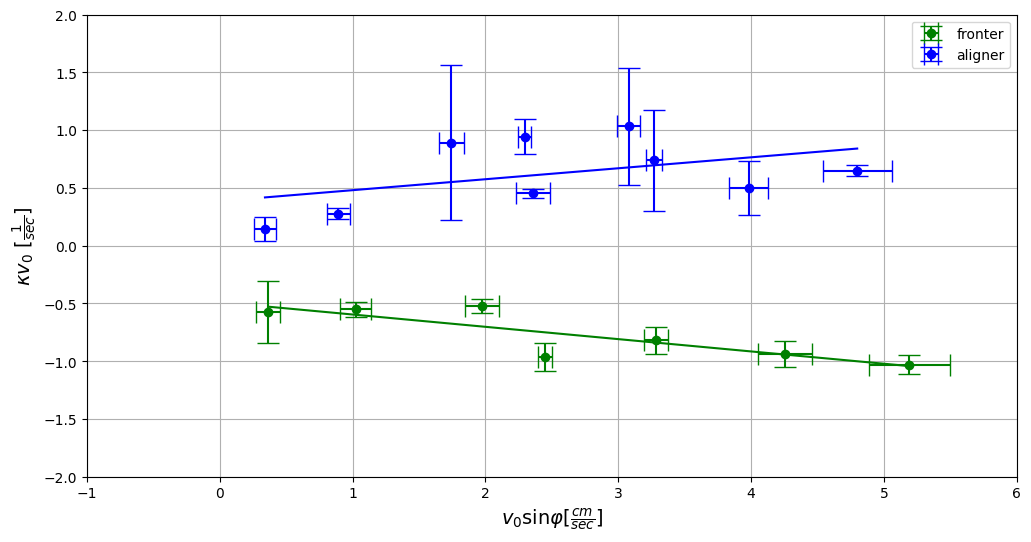

In [35]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
zero_deg_fron=8.325#deg
v0_fron=3.77#cm/sec
zero_deg_err_fron=1.075
mu_f_0_fron=v0_fron/np.sin(np.deg2rad(zero_deg_fron))
data_mean=data_table.groupby(['bottype','slope']).mean()
data_std=data_table.groupby(['bottype','slope']).std()
data_count=data_table.groupby(['bottype','slope']).count()
data_mean.to_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\kappa_meas_made_bots\\data_mean.csv')
data_std.to_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\kappa_meas_made_bots\\data_std.csv')
data_count.to_csv('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\kappa_meas_made_bots\\data_count.csv')
index_fron=data_mean['A'].loc['fronter'].index
data_mean_fron=data_mean['A'].loc['fronter']
data_std_fron=data_std['A'].loc['fronter']
data_count_fron=data_count['A'].loc['fronter']
data_error_fron=data_std_fron/np.sqrt(data_count_fron)
slope_err_fron=data_mean['slope_err'].loc['fronter']
mu_f_0_err_fron=np.deg2rad(slope_err_fron)*v0_fron*np.cos(np.deg2rad(zero_deg_fron))/((np.sin(np.deg2rad(zero_deg_fron)))**2)
mu_f_fron=mu_f_0_fron*np.sin(np.deg2rad(index_fron))
mu_f_err_fron=np.sqrt((mu_f_0_err_fron*np.sin(np.deg2rad(index_fron)))**2+(mu_f_0_fron*np.cos(np.deg2rad(index_fron))*np.deg2rad(slope_err_fron))**2)

zero_deg_align=8.325#deg
v0_align=3.53#cm/sec
zero_deg_err_align=1.075
mu_f_0_align=v0_align/np.sin(np.deg2rad(zero_deg_align))
#index_align=data_mean['A'].loc['aligner'].index
data_mean_align=data_mean['A'].loc['aligner']
data_mean_align.loc[5.40]=0.941655
data_mean_align.loc[7.25]=1.032153
#data_mean_align= data_mean_align.drop(labels=[4.10,5.40,7.25])
index_align=data_mean_align.index
data_std_align=data_std['A'].loc['aligner']
#data_std_align=data_std_align.drop(labels=[4.10,5.40,7.25])
data_count_align=data_count['A'].loc['aligner']
#data_count_align=data_count_align.drop(labels=[4.10,5.40,7.25])
data_error_align=data_std_align/np.sqrt(data_count_align)
slope_err_align=data_mean['slope_err'].loc['aligner']
#slope_err_align=slope_err_align.drop(labels=[4.10,5.40,7.25])
mu_f_0_err_align=np.deg2rad(slope_err_align)*v0_fron*np.cos(np.deg2rad(zero_deg_align))/((np.sin(np.deg2rad(zero_deg_align)))**2)
mu_f_align=mu_f_0_align*np.sin(np.deg2rad(index_align))
mu_f_err_align=np.sqrt((mu_f_0_err_align*np.sin(np.deg2rad(index_align)))**2+(mu_f_0_align*np.cos(np.deg2rad(index_align))*np.deg2rad(slope_err_align))**2)

ax.errorbar(mu_f_fron,data_mean_fron,yerr=data_error_fron,xerr=mu_f_err_fron
            ,linestyle='',marker='o',color='g',label='fronter',capsize=8)
p0=np.array([0.09,1])
popt_fron,pcov_fron = sc.optimize.curve_fit(linearfit,mu_f_fron,data_mean_fron,p0=p0,maxfev=5000)
print(popt_fron)
perr_fron = np.sqrt(np.diag(pcov_fron))
print(perr_fron)
y_fron=popt_fron[0]*mu_f_fron+popt_fron[1]

ax.errorbar(mu_f_align,data_mean_align,yerr=data_error_align,xerr=mu_f_err_align
            ,linestyle='',marker='o',color='b',label='aligner',capsize=8)
popt_align,pcov_align = sc.optimize.curve_fit(linearfit,mu_f_align,data_mean_align,p0=p0,maxfev=5000)
print(popt_align)
perr_align = np.sqrt(np.diag(pcov_align))
print(perr_align)
y_align=popt_align[0]*mu_f_align+popt_align[1]

ax.plot(mu_f_fron,y_fron,color='g')
ax.plot(mu_f_align,y_align,color='b')
ax.set_xlabel(r'$v_0$sin$\varphi$$[\frac{cm}{sec}]$',fontsize=14)
ax.set_ylabel(r'$\kappa v_0$ $[\frac{1}{sec}]$',fontsize=14)
ax.grid()
ax.legend()
ax.axis([-1,6,-2,2])
fig.savefig('C:\\Users\\User\\Documents\\Eden\\locate_git_code\\kappa_meas_made_bots\\kappaV0_Vs_v0sinphi.png')